# Fake News Detection

## Import necessary libraries

In [41]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santhosh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/santhosh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load dataset

In [2]:
df = pd.read_csv("./dataset/news.csv",index_col=0)
df.head()

,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Exploratory Data Analysis

In [3]:
print("Number of fake news:", df[df["label"]=="FAKE"].shape[0])
print("Number of real news:", df[df["label"]=="REAL"].shape[0])
print("Total number of news:", df.shape[0])

Number of fake news: 3164
Number of real news: 3171
Total number of news: 6335


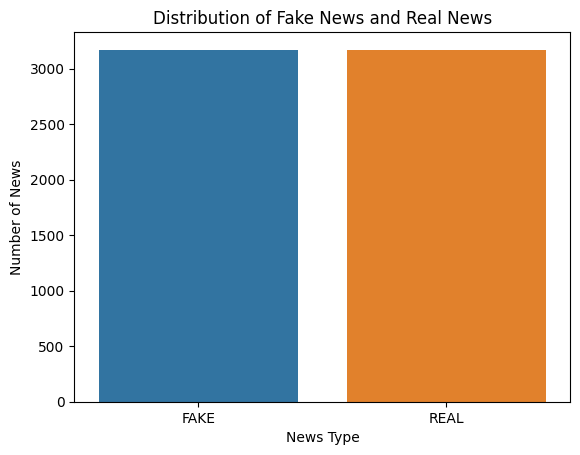

In [4]:
sns.countplot(x = df['label'])
plt.title('Distribution of Fake News and Real News')
plt.xlabel('News Type')
plt.ylabel('Number of News')
plt.show()

The dataset is balanced with the number of fake and real news sample being nearly equal.

In [5]:
# Checking for null values
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [6]:
# Checking for empty rows
print("title", df.title[df.title.str.strip()==''].count())
print("text", df.text[df.text.str.strip()==''].count())

title 0
text 36


Although there is no null value in any column, 36 rows in text column have empty text

In [7]:
# Check for duplicate rows
df.duplicated().sum()

29

There are 29 duplicate rows in the dataset

## Data Preprocessing

### Remove duplicate rows

In [8]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

In [9]:
df.duplicated().sum()

0

### Drop rows with empty text

In [10]:
df.drop(df.text[df.text.str.strip()==''].index,inplace=True)
df.reset_index(inplace=True,drop=True)

In [11]:
df.text[df.text.str.strip()==''].count()

0

### Concatenate title and text column

In [12]:
df["text"] = df["title"] + " " + df["text"]
df.drop("title",axis=1,inplace=True)

In [13]:
df.head()

,text,label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,Kerry to go to Paris in gesture of sympathy U....,REAL
3,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,The Battle of New York: Why This Primary Matte...,REAL


### Converting text to lowercase

In [14]:
df["text"] = df["text"].str.lower()

In [15]:
df.head()

,text,label
0,you can smell hillary’s fear daniel greenfield...,FAKE
1,watch the exact moment paul ryan committed pol...,FAKE
2,kerry to go to paris in gesture of sympathy u....,REAL
3,bernie supporters on twitter erupt in anger ag...,FAKE
4,the battle of new york: why this primary matte...,REAL


### Remove punctuations

In [23]:
def remove_punctuations(column):
    punctuation_signs = list("?:!.,;:'()@-—")
    column = column.str.replace("\r", " ")
    column = column.str.replace("\n", " ")
    column = column.str.replace("    ", " ")
    column = column.str.replace('"', ' ')
    column = column.str.lower()
    for punct_sign in punctuation_signs:
        column = column.str.replace(punct_sign, ' ')
    column = column.str.replace("'s", " ")
    column = column.str.replace("|"," ")
    column = column.str.replace("'"," ")
    column = column.str.replace(","," ")
    return column

In [24]:
df["text"] = remove_punctuations(df["text"])

In [26]:
df.head()

,text,label
0,you can smell hillary’s fear daniel greenfield...,FAKE
1,watch the exact moment paul ryan committed pol...,FAKE
2,kerry to go to paris in gesture of sympathy u ...,REAL
3,bernie supporters on twitter erupt in anger ag...,FAKE
4,the battle of new york why this primary matte...,REAL


### Lemmatizing the text

In [27]:
lemmatizer = WordNetLemmatizer()

In [28]:
df["text"] = df["text"].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

In [29]:
df.iloc[4].text

'the battle of new york why this primary matter it s primary day in new york and front runner hillary clinton and donald trump are leading in the poll trump is now vowing to win enough delegate to clinch the republican nomination and prevent a contested convention but sen ted cruz r texas bernie sander d vt and ohio gov john kasich and aren t giving up just yet a big win in new york could tip the scale for both the republican and democratic front runner in this year s race for the white house clinton and trump have each suffered loss in recent contest shifting the momentum to their rival we have won eight out of the last nine caucus and primary cheer sander recently told supporter while win in new york for trump and clinton are expected the margin of those victory are also important trump need to capture more than 50 percent of the vote statewide if he want to be positioned to win all of the state s 95 gop delegate that would put him one step closer to avoiding a contested convention w

### Removing stop words

In [30]:
stop = stopwords.words('english')

In [31]:
for word in stop:
    df["text"] = df["text"].str.replace(" "+word+" ", ' ')

In [32]:
df.head()

,text,label
0,you smell hillary’s fear daniel greenfield shi...,FAKE
1,watch exact moment paul ryan committed politic...,FAKE
2,kerry go paris gesture sympathy u secretary st...,REAL
3,bernie supporter twitter erupt anger dnc tried...,FAKE
4,the battle new york primary matter primary day...,REAL


### Encoding the label column

In [38]:
df["label"] = df["label"].apply(lambda x: 0 if x=="REAL" else 1)

In [39]:
df.head()

,text,label
0,you smell hillary’s fear daniel greenfield shi...,1
1,watch exact moment paul ryan committed politic...,1
2,kerry go paris gesture sympathy u secretary st...,0
3,bernie supporter twitter erupt anger dnc tried...,1
4,the battle new york primary matter primary day...,0


## Training the model

### Splitting the data into train and text set

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

### Creating feature extraction pipeline using Count Vectorizer and TFIDF Transformer

In [43]:
pipeline = Pipeline([
    ("count", CountVectorizer()),
    ("tfidf", TfidfTransformer())
])

In [44]:
pipeline.fit(X_train)

Pipeline(steps=[('count', CountVectorizer()), ('tfidf', TfidfTransformer())])

In [45]:
X_train = pd.DataFrame(pipeline.transform(X_train).toarray())

In [46]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,56937,56938,56939,56940,56941,56942,56943,56944,56945,56946
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_test = pd.DataFrame(pipeline.transform(X_test).toarray())

### Using PassiveAgressive Classifer to train the model

In [48]:
pac = PassiveAggressiveClassifier()

In [49]:
pac.fit(X_train,y_train)

PassiveAggressiveClassifier()

## Evaluating the model

In [50]:
y_pred = pac.predict(X_test)

In [51]:
print(f"Accuracy of classifier: {accuracy_score(y_test,y_pred)*100}%")

Accuracy of classifier: 94.01913875598086%


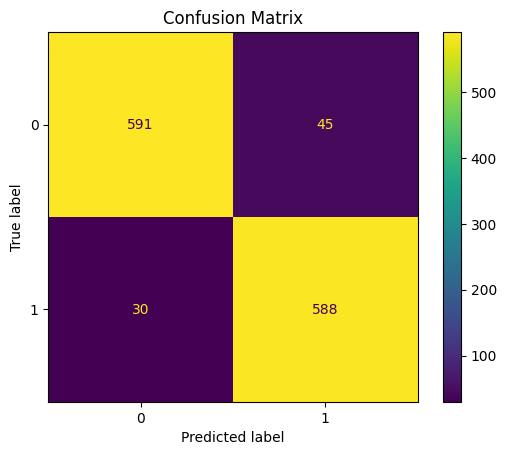

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.title("Confusion Matrix")
plt.show()